
### <span style="color:red;">데이터셋 및 모델의 크기가 크므로 본 실습파일은 <b>Google Colab 에서 실행</b>하기를 적극 권장합니다.</span>
    
### Colab 에서 이 ipynb 파일을 업로드하고, [ <span style="color:red;">(상단 메뉴) 런타임 -> 런타임 유형 변경 -> GPU</span> ] 선택 후 실행해주세요.

<br>

In [2]:
import random
import zipfile
import shutil
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings                   
warnings.filterwarnings('ignore')

<br>
<br>

## 1. Prepare the dataset

<br>
<br>

The full dataset for the kaggle challenge is provided by Microsoft. 
<br> You can find it here [ https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765 ]. 

<br> See the instructions in the comments if the URL in the following code block doesn't work.

In [3]:
# # If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# # And right click on the 'Download Manually' link to get a new URL to the dataset 

# # Note: This is a very large dataset and will take time to download
!wget --no-check-certificate "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/'))) 

# # Expected Output:
# # 12501
# # 12501

--2022-03-03 15:41:20--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.33.136.128, 2600:1402:2000:1bb::e59, 2600:1402:2000:193::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.33.136.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   153MB/s    in 5.4s    

2022-03-03 15:41:26 (146 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]

12501
12501


In [ ]:
# # Windows OS 로컬 환경에서 진행 시 
# # 1) https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765 링크에서 데이터 다운로드
# # 2) 다운로드된 압축파일의 위치 변경 -> data 폴더 내로 이동
# # 3) 다운로드된 압축파일의 이름 변경 -> "cats-and-dogs.zip"
# # 4) 아래 코드 실행

# local_zip = 'data/cats-and-dogs.zip'
# zip_ref   = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('data')
# zip_ref.close()

# print(len(os.listdir('data/PetImages/Cat/')))
# print(len(os.listdir('data/PetImages/Dog/'))) 


# # 그 다음 아래 셀부터 나타나는 코드에서 "/tmp/"를 모두 "data/" 로 바꿔줘야 합니다.

Now that you downloaded the data, **unzip it into training and testing directories**. 
<br>The following code achieves that:

In [4]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        shutil.copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        shutil.copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"
 
split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [5]:
# You can check to see if your data is properly unpacked using the following code:
    
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

# Expected output:
# 11250
# 11250
# 1250
# 1250

11250
11250
1250
1250


<br>
<br>

## 2. Build a CNN-model & Use DataGenerator to train the model
<br>
<br>

In [6]:
model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
]) 

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

<br>
<br>

Now that the model is defined, 
<br>you can train the model using an **ImageDataGenerator**.

In [7]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))
 
VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))
 
# Expected Output:
# Found 22498 images belonging to 2 classes.
# Found 2500 images belonging to 2 classes.

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


<br>
<br>

To train the model, you now call **model.fit_generator**, 
<br>passing it to the generators that you created.

In [8]:
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
225/225 [==============================] - 88s 340ms/step - loss: 0.7902 - accuracy: 0.6077 - val_loss: 0.5840 - val_accuracy: 0.7184
Epoch 2/15
225/225 [==============================] - 76s 339ms/step - loss: 0.5479 - accuracy: 0.7233 - val_loss: 0.4584 - val_accuracy: 0.7832
Epoch 3/15
225/225 [==============================] - 75s 333ms/step - loss: 0.4661 - accuracy: 0.7792 - val_loss: 0.5149 - val_accuracy: 0.7252
Epoch 4/15
225/225 [==============================] - 75s 333ms/step - loss: 0.4023 - accuracy: 0.8169 - val_loss: 0.3173 - val_accuracy: 0.8576
Epoch 5/15
225/225 [==============================] - 75s 331ms/step - loss: 0.3402 - accuracy: 0.8487 - val_loss: 0.2385 - val_accuracy: 0.9028
Epoch 6/15
225/225 [==============================] - 74s 328ms/step - loss: 0.2685 - accuracy: 0.8867 - val_loss: 0.1740 - val_accuracy: 0.9408
Epoch 7/15
225/225 [==============================] - 74s 327ms/step - loss: 0.1993 - accuracy: 0.9215 - val_loss: 0.1233 - val_ac

<Figure size 432x288 with 0 Axes>

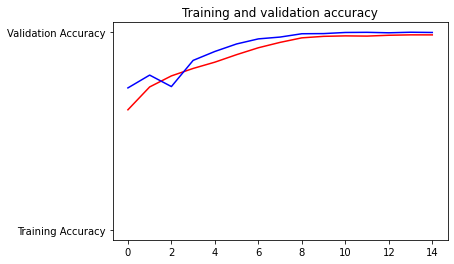

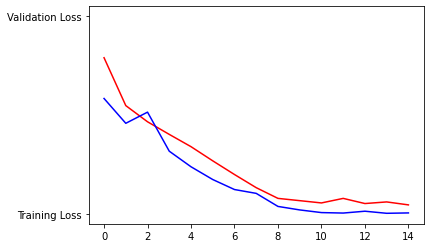

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
%matplotlib inline


#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc)) # Get number of epochs
 

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()
 

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()

<br>
<br>

If you want to take the model for a spin, you can use the following code. 
<br>Upload images to see how it classifies them!

In [10]:
# 아래 특정 이미지를 대상으로 한 prediction을 Windows OS 에서 진행할 경우,
# 앞선 실습 파일인 4번 파일의 [ 3. Predict on an image & visualize the layer and filter ] 코드를 활용해주세요.

# Here's a codeblock just for fun. 
# You should be able to upload an image here and have it classified without crashing

import numpy as np
from google.colab import files
from keras.preprocessing import image
 
uploaded = files.upload()
 
for fn in uploaded.keys(): 
    
    # predicting images
    path = '/content/' + fn
    img = image.load_img(path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes[0])
    if classes[0]>0.5:
        print(fn + " is a dog")
    else:
        print(fn + " is a cat")

Saving dog_1.jpg to dog_1.jpg
[1.]
dog_1.jpg is a dog
